In [74]:
import numpy as np
import random
import scipy
import networkx as nx
import pymatching
from pymatching import Matching
from pymatching import set_seed
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
import time
from itertools import cycle
import pickle
import multiprocessing as mp
np.seterr(divide='ignore')
from functools import partial
import qecsim
from qecsim import app
from qecsim.models.generic import PhaseFlipErrorModel,DepolarizingErrorModel,BiasedDepolarizingErrorModel
from qecsim import paulitools as pt

def rotdic_pbc(Nx,Ny):

    v=np.zeros((Nx,Ny),dtype=int)

    for i in range(0,Nx):
        for j in range(0,Ny):
            if (i+j)%2==0: 
                if j%2==0:
                    v[i,j]=i/2+((j-1)%Nx)*Nx/2
                else:
                    v[i,j]=((i-1)%Nx)/2+((j-1)%Nx)*Nx/2
            if (i+j)%2==1:
                if j%2==0:
                    v[i,j]=((i-1)%Nx)/2+((j-1)%Nx)*Nx/2
                else:
                    v[i,j]=i/2+((j-1)%Nx)*Nx/2     
    return v


def rotdic_obc(Nx,Ny):

    Zstabs_num=(Nx/2+1)*Ny
    Xstabs_num=Nx/2*(Ny+2)   
    
    virZ1,virZ2=Zstabs_num,Zstabs_num+1
    virX1,virX2=Xstabs_num,Xstabs_num+1
    vX=(-10)*np.ones((Nx+4,Ny+4),dtype=int)

    for i in range(1,Nx+3):
        for j in range(1,Ny+3):
            if (i+j)%2==0: 
                if j==1:
                    vX[i,j]=virX1
                elif j==Ny+2:
                    vX[i,j]=virX2                      
                else:
                    if j%2==0:
                        vX[i,j]=(i-2)/2+(j-2)*(Nx/2+1)
                    else:
                        vX[i,j]=(i-1)/2+(j-2)*(Nx/2+1)


    vZ=(-10)*np.ones((Nx+4,Ny+4),dtype=int)

    for i in range(1,Nx+3):
        for j in range(1,Ny+3):
            if (i+j)%2==1:
                if i==1:
                    vZ[i,j]=virZ1
                elif i==Nx+2:
                    vZ[i,j]=virZ2      
                else:
                    vZ[i,j]=(i-2)/2+(j-1)*Nx/2

    return [vX,vZ]

def planardic_pbc(Nx,Ny):

    vX=np.zeros((Nx,Ny))
    for i in range(0,Nx):
        for j in range(0,Ny):
            vX[i,j]=i+j*Nx
    vZ=vX 
    return [vX,vZ]

def planardic_obc(Nx,Ny):

    Zerr_syndrome_num,Xerr_syndrome_num=Nx*Ny,(Nx+1)*(Ny-1)
    virZ1,virZ2=Zerr_syndrome_num,Zerr_syndrome_num+1
    virX1,virX2=Xerr_syndrome_num,Xerr_syndrome_num+1

    vX=np.zeros((Nx+2,Ny+2),dtype=int)

    for i in range(0,Nx+2):
        for j in range(0,Ny+2):
            if j==0:
                vX[i,j]=virX1
            elif j==Ny:
                vX[i,j]=virX2
            else:
                vX[i,j]=i-1+(j-1)*(Nx+1)

    vZ=np.zeros((Nx+2,Ny+2),dtype=int)

    for i in range(0,Nx+2):
        for j in range(1,Ny+1):
            if i==0:
                vZ[i,j]=virZ1
            elif i==Nx+1:
                vZ[i,j]=virZ2
            else:
                vZ[i,j]=i-1+(j-1)*Nx
    return [vX,vZ]


def decoder_graphs(Nx,Ny,prob_dist,periodic,rotated):

    pI,pX,pY,pZ=prob_dist

    #weights
    wZ=abs(np.log(pZ/pI))
    wX=abs(np.log(pX/pI))

    if rotated==1:
        if periodic==0:
            #even times even stabilizer number lattice
            Xstabs_num=(Nx/2+1)*Ny
            Zstabs_num=Nx/2*(Ny+2)

            virZ1,virZ2=Zstabs_num,Zstabs_num+1
            virX1,virX2=Xstabs_num,Xstabs_num+1
            
            [vX,vZ]=rotdic_obc(Nx,Ny)

            Graph_Zerr=nx.MultiGraph()
            Graph_Xerr=nx.MultiGraph()

            X_logical1_Graph_Zerr=np.array([],dtype=int)
            Z_logical1_Graph_Xerr=np.array([],dtype=int)

            id=0
            for i in range(1,Nx+3):
                for j in range(1,Ny+3): 
                    if (i+j)%2==1:
                        if vZ[i+1,j+1]>-1:
    #                         print(i,j,vZ[i,j],vZ[i+1,j+1])
                            Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j+1],qubit_id=id,weight=wZ,error_probability=pZ)
                            Graph_Xerr.add_edge(vX[i,j+1],vX[i+1,j],qubit_id=id,weight=wX,error_probability=pX)
                            id+=1
                        if vZ[i+1,j-1]>-1:
    #                         print(i,j,vZ[i,j],vZ[i+1,j-1])                        
                            Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j-1],qubit_id=id,weight=wZ,error_probability=pZ)
                            Graph_Xerr.add_edge(vX[i,j-1],vX[i+1,j],qubit_id=id,weight=wX,error_probability=pX)
                            id+=1
            
            # print('id=',id)
            Graph_Zerr.add_edge(virZ1,virZ2,qubit_id=-1,weight=0,error_probability=0)  
            Graph_Xerr.add_edge(virX1,virX2,qubit_id=-1,weight=0,error_probability=0) 

            Z_logical_qubit_num=Nx+1  
            X_logical_qubit_num=Ny    

            w=0
            for j in range(1,Ny+3):
                if (2+j)%2==1:
                    if vZ[3,j+1]>-1:
                        X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[vZ[2,j]][vZ[3,j+1]][w]['qubit_id'])
                    if vZ[3,j-1]>-1:              
                        X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[vZ[2,j]][vZ[3,j-1]][w]['qubit_id'])

            for i in range(1,Nx+3):
                if (i+2)%2==0:
                    if vX[i+1,3]>-1:
                        Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[vX[i,2]][vX[i+1,3]][w]['qubit_id'])
                    if vX[i-1,3]>-1:
                        Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[vX[i,2]][vX[i-1,3]][w]['qubit_id'])

            Graph_Zerr.nodes[virZ1]['is_boundary']=True
            Graph_Zerr.nodes[virZ2]['is_boundary']=True
            Graph_Xerr.nodes[virX1]['is_boundary']=True   
            Graph_Xerr.nodes[virX2]['is_boundary']=True    

            return [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]

        else: 
            v=rotdic_pbc(Nx,Ny)

            Graph_Zerr=nx.MultiGraph()
            Graph_Xerr=nx.MultiGraph()
            
            #Nx and Ny are number of stabilizers
            
            if (Nx%2==0 and Ny%2==0):
                X_logical1_Graph_Zerr=np.array([],dtype=int)
                X_logical2_Graph_Zerr=np.array([],dtype=int)
                Z_logical1_Graph_Xerr=np.array([],dtype=int)
                Z_logical2_Graph_Xerr=np.array([],dtype=int)

                id=0
                for i in range(0,Nx):
                    for j in range(0,Ny):
                        if (i+j)%2==0:
                            Graph_Zerr.add_edge(v[i,j],v[(i+1)% Nx,(j+1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                            Graph_Xerr.add_edge(v[i,(j+1)%Ny],v[(i+1)%Nx,j],qubit_id=id,weight=wX,error_probability=pX)
                            id+=1
                            Graph_Zerr.add_edge(v[i,j],v[(i+1)%Nx,(j-1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                            Graph_Xerr.add_edge(v[i,(j-1)%Ny],v[(i+1)%Nx,j],qubit_id=id,weight=wX,error_probability=pX)
                            id+=1

                w=0
                for i in range(0,Nx):
                    for j in range(0,Ny):
                        if (i+j)%2==0 and i==0:
                            X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id'])                        
                            X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[v[i,j]][v[(i+1)%Nx,(j-1)%Ny]][w]['qubit_id'])                        
                        if (i+j)%2==0 and j==0:
                            X_logical2_Graph_Zerr=np.append(X_logical2_Graph_Zerr,Graph_Zerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id'])
                            X_logical2_Graph_Zerr=np.append(X_logical2_Graph_Zerr,Graph_Zerr[v[i,j]][v[(i-1)%Nx,(j+1)%Ny]][w]['qubit_id'])
                        if (i+j)%2==1 and i==0:
                            Z_logical2_Graph_Xerr=np.append(Z_logical2_Graph_Xerr,Graph_Xerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id'])
                            Z_logical2_Graph_Xerr=np.append(Z_logical2_Graph_Xerr,Graph_Xerr[v[i,j]][v[(i+1)%Nx,(j-1)%Ny]][w]['qubit_id'])
                        if (i+j)%2==1 and j==0:
                            Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id'])
                            Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[v[i,j]][v[(i-1)%Nx,(j+1)%Ny]][w]['qubit_id'])

                return [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,X_logical2_Graph_Zerr,Z_logical1_Graph_Xerr,Z_logical2_Graph_Xerr]

        
            elif(Nx%2!=Ny%2):
                print('the modified decoder graphs and logicals (which are now a Y-Z or Y-X pair) needs to be implemented below')
                X_logical1_Graph_Zerr=np.array([],dtype=int)
                Z_logical1_Graph_Xerr=np.array([],dtype=int)

                id=0
                for i in range(0,Nx):
                    for j in range(0,Ny):
                        if (i+j)%2==0:
                            Graph_Zerr.add_edge(v[i,j],v[(i+1)% Nx,(j+1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                            Graph_Xerr.add_edge(v[i,(j+1)%Ny],v[(i+1)%Nx,j],qubit_id=id,weight=wX,error_probability=pX)
                            id+=1
                            Graph_Zerr.add_edge(v[i,j],v[(i+1)%Nx,(j-1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                            Graph_Xerr.add_edge(v[i,(j-1)%Ny],v[(i+1)%Nx,j],qubit_id=id,weight=wX,error_probability=pX)
                            id+=1
                
                w=0
                for i in range(0,Nx):
                    for j in range(0,Ny):
                        if v[i,j] in range(0,Nx*Ny,Nx):
                            X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id'])
                        if v[i,j] in range(0,Nx):
                            Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id'])

                return [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]
    else:
        if periodic==0:
            Zerr_syndrome_num,Xerr_syndrome_num=Nx*Ny,(Nx+1)*(Ny-1)
            virZ1,virZ2=Zerr_syndrome_num,Zerr_syndrome_num+1
            virX1,virX2=Xerr_syndrome_num,Xerr_syndrome_num+1

            [vX,vZ]=planardic_obc(Nx,Ny)

            Graph_Zerr=nx.MultiGraph()
            Graph_Xerr=nx.MultiGraph()

            X_logical1_Graph_Zerr=np.array([],dtype=int)
            Z_logical1_Graph_Xerr=np.array([],dtype=int)

            #construct the Z lattice
            id=0
            for i in range(1,Nx+1):
                for j in range(1,Ny+1):
                    if j==Ny:
                        Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j],qubit_id=id,weight=wZ,error_probability=pZ)  
                        Graph_Xerr.add_edge(vX[i+1,j-1],vX[i+1,j],qubit_id=id,weight=wX,error_probability=pX) 
                        id+=1
                    else:
                        Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j],qubit_id=id,weight=wZ,error_probability=pZ)  
                        Graph_Xerr.add_edge(vX[i+1,j-1],vX[i+1,j],qubit_id=id,weight=wX,error_probability=pX) 
                        id+=1
                        Graph_Zerr.add_edge(vZ[i,j],vZ[i,j+1],qubit_id=id,weight=wZ,error_probability=pZ) 
                        Graph_Xerr.add_edge(vX[i,j],vX[i+1,j],qubit_id=id,weight=wX,error_probability=pX)
                        id+=1
                    if i==1:
                        Graph_Zerr.add_edge(vZ[i-1,j],vZ[i,j],qubit_id=id,weight=wZ,error_probability=pZ)  
                        Graph_Xerr.add_edge(vX[i,j-1],vX[i,j],qubit_id=id,weight=wX,error_probability=pX) 
                        id+=1

            Graph_Zerr.add_edge(virZ1,virZ2,qubit_id=-1,weight=0,error_probability=0)  
            Graph_Xerr.add_edge(virX1,virX2,qubit_id=-1,weight=0,error_probability=0) 

            Graph_Zerr.nodes[virZ1]['is_boundary']=True
            Graph_Zerr.nodes[virZ2]['is_boundary']=True
            Graph_Xerr.nodes[virX1]['is_boundary']=True   
            Graph_Xerr.nodes[virX2]['is_boundary']=True   

            Z_logical_qubit_num=Nx+1  
            X_logical_qubit_num=Ny    

            
            w=0
            for i in range(1,Nx+1):
                for j in range(1,Ny+1):
                    if vZ[i,j]in range(0,Nx*Ny,Nx):
                        X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[vZ[i,j]][virZ1][w]['qubit_id'])

            for i in range(1,Nx+2):
                for j in range(1,Ny):
                    if vX[i,j]in range(0,Nx+1):
                        Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[vX[i,j]][virX1][w]['qubit_id'])

#             for i in range(1,Nx+1):
#                 for j in range(1,Ny+1):
#                     if vZ[i][j] in range(0,Nx*Ny,Nx):
#                         X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[vZ[i][j]][vZ[i+1][j]][w]['qubit_id'])
#                     if vX[i][j] in range(0,Nx+1):
#                         Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[vX[i][j]][vX[i][j+1]][w]['qubit_id'])
            return [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]

        else: 
            [vX,vZ]=planardic_pbc(Nx,Ny)

            Graph_Zerr=nx.MultiGraph()
            Graph_Xerr=nx.MultiGraph()

            X_logical1_Graph_Zerr=np.array([],dtype=int)
            X_logical2_Graph_Zerr=np.array([],dtype=int)
            Z_logical1_Graph_Xerr=np.array([],dtype=int)
            Z_logical2_Graph_Xerr=np.array([],dtype=int)

            id=0
            for i in range(0,Nx):
                for j in range(0,Ny):
                    Graph_Zerr.add_edge(vZ[i][j],vZ[(i+1)% Nx][j],qubit_id=id,weight=wZ,error_probability=pZ)
                    Graph_Xerr.add_edge(vX[(i+1)%Nx][(j-1)%Ny],vX[(i+1)%Nx][j],qubit_id=id,weight=wX,error_probability=pX)
                    id+=1
                    Graph_Zerr.add_edge(vZ[i][j],vZ[i][(j+1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                    Graph_Xerr.add_edge(vX[i][j],vX[(i+1)% Nx][j],qubit_id=id,weight=wX,error_probability=pX)
                    id+=1

            w=0
            for i in range(0,Nx):
                for j in range(0,Ny):
                    if vZ[i][j] in range(0,Nx*Ny,Nx):
                        X_logical1_Graph_Zerr=np.append(X_logical1_Graph_Zerr,Graph_Zerr[vZ[i][j]][vZ[(i+1)% Nx][j]][w]['qubit_id'])
                    if vX[i][j] in range(0,Nx):
                        Z_logical1_Graph_Xerr=np.append(Z_logical1_Graph_Xerr,Graph_Xerr[vX[i][j]][vX[i][(j+1)%Ny]][w]['qubit_id'])
                    if vZ[i][j] in range(0,Nx):
                        X_logical2_Graph_Zerr=np.append(X_logical2_Graph_Zerr,Graph_Zerr[vZ[i][j]][vZ[i][(j+1)%Ny]][w]['qubit_id'])
                    if vX[i][j] in range(0,Nx*Ny,Nx):
                        Z_logical2_Graph_Xerr=np.append(Z_logical2_Graph_Xerr,Graph_Xerr[vX[i][j]][vX[(i+1)% Nx][j]][w]['qubit_id'])

            return [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,X_logical2_Graph_Zerr,Z_logical1_Graph_Xerr,Z_logical2_Graph_Xerr]

def graph_temp(Nx,Ny,prob_dist,periodic,rotated):

    pI,pX,pY,pZ=prob_dist

    #weights
    wZ=abs(np.log(pZ/pI))
    wX=abs(np.log(pX/pI))
  
    if rotated==1:
        if periodic==0:
            #even times even stabilizer number lattice
            Zerr_syndrome_num=(Nx/2+1)*Ny
            virZ1,virZ2=Zerr_syndrome_num,Zerr_syndrome_num+1
            [vX,vZ]=rotdic_obc(Nx,Ny)
            Graph_Zerr=nx.MultiGraph()
            id=0
            for i in range(1,Nx+3):
                for j in range(1,Ny+3): 
                    if (i+j)%2==1:
                        if vZ[i+1,j+1]>-1:
                            Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j+1],qubit_id=id,weight=wZ,error_probability=pZ)
                            id+=1
                        if vZ[i+1,j-1]>-1:
                            Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j-1],qubit_id=id,weight=wZ,error_probability=pZ)
                            id+=1
                        
            Graph_Zerr.add_edge(virZ1,virZ2,qubit_id=-1,weight=0,error_probability=0)  

            Graph_Zerr.nodes[virZ1]['is_boundary']=True
            Graph_Zerr.nodes[virZ2]['is_boundary']=True

        else: 
            v=rotdic_pbc(Nx,Ny)
            Graph_Zerr=nx.MultiGraph()  
            id=0                      
            if (Nx%2==0 and Ny%2==0):
                for i in range(0,Nx):
                    for j in range(0,Ny):
                        if (i+j)%2==0:
                            Graph_Zerr.add_edge(v[i,j],v[(i+1)% Nx,(j+1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                            id+=1
                            Graph_Zerr.add_edge(v[i,j],v[(i+1)%Nx,(j-1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                            id+=1

    else:
        Graph_Zerr=nx.MultiGraph()

        id=0
        if(periodic==1):
            [vX,vZ]=planardic_pbc(Nx,Ny)
            for i in range(0,Nx):
                for j in range(0,Ny):
                    Graph_Zerr.add_edge(vZ[i][j],vZ[(i+1)%Nx][j],qubit_id=id,weight=wZ,error_probability=pZ)
                    id+=1

                    Graph_Zerr.add_edge(vZ[i][j],vZ[i][(j+1)%Ny],qubit_id=id,weight=wZ,error_probability=pZ)
                    id+=1
        else:
            virZ1,virZ2=Nx*Ny,Nx*Ny+1
            [vX,vZ]=planardic_obc(Nx,Ny)
            for i in range(1,Nx+1):
                for j in range(1,Ny+1):
                    if j==Ny:
                        Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j],qubit_id=id,weight=wZ,error_probability=pZ)  
                        id+=1
                    else:
                        Graph_Zerr.add_edge(vZ[i,j],vZ[i+1,j],qubit_id=id,weight=wZ,error_probability=pZ)  
                        id+=1
                        Graph_Zerr.add_edge(vZ[i,j],vZ[i,j+1],qubit_id=id,weight=wZ,error_probability=pZ) 
                        id+=1
                    if i==1:
                        Graph_Zerr.add_edge(vZ[i-1,j],vZ[i,j],qubit_id=id,weight=wZ,error_probability=pZ)  
                        id+=1

            Graph_Zerr.add_edge(virZ1,virZ2,qubit_id=-1,weight=0,error_probability=0)    

    return Graph_Zerr



def weight_error_changes(prob_dist,Graph_Xerr,Graph_Zerr,periodic,rotated,hadamard_vec):
  
    pI,pX,pY,pZ=prob_dist

    #weights
    wZ=abs(np.log(pZ/pI))
    wX=abs(np.log(pX/pI))
    
    if periodic==1:
        nqubits=len(Graph_Zerr.edges)
    else:
        nqubits=len(Graph_Zerr.edges)-1

    for ind in range(nqubits):
        if (hadamard_vec[ind]==1):
            for (u,v,w) in list(Graph_Zerr.edges):
                if Graph_Zerr[u][v][w]['qubit_id']==ind:
                    Graph_Zerr[u][v][w]['weight']=wX
                    Graph_Zerr[u][v][w]['error_probability']=pX
            for (u,v,w) in list(Graph_Xerr.edges):
                if Graph_Xerr[u][v][w]['qubit_id']==ind:
                    Graph_Xerr[u][v][w]['weight']=wZ
                    Graph_Xerr[u][v][w]['error_probability']=pZ

    return [Graph_Xerr,Graph_Zerr]


def spiral_torus(Nx,pitch):    
    Ny=Nx
    [vX,vZ]=planardic_pbc(Nx,Ny)

    L_left=np.int_([Nx-1])
    pitch_left=np.int_([pitch])
    xcoord_pitch=np.int_([np.floor(L_left[-1]/pitch_left[-1])])

    while (pitch_left[-1]>1):
        L_left=np.append(L_left,L_left[-1]-int(np.floor(L_left[-1]/pitch_left[-1]))-1)
        pitch_left=np.append(pitch_left,pitch_left[-1]-1)
        xcoord_pitch=np.append(xcoord_pitch,xcoord_pitch[-1]+int(np.floor(L_left[-1]/pitch_left[-1]))+1)
    spiral=np.zeros((2*pitch*Nx,3))
    pitch_count=0
    
    w=0
    for ist_temp in xcoord_pitch:
        ist=ist_temp
        jst=0
        for ind in range(2*Ny):
            if ind%2==0:
                spiral[ind+pitch_count*2*Ny]=[vZ[ist][jst],vZ[(ist+1)%Nx][jst],w]
                ist=(ist+1)%Nx
            else:
                spiral[ind+pitch_count*2*Ny]=[vZ[ist][jst],vZ[ist][(jst+1)%Ny],w]
                jst=(jst+1)%Ny
        pitch_count=pitch_count+1

    return spiral

def func_hadamard_vec(Nx,Ny,pH,prob_dist,periodic,rotated,pitch):

    Graph_Zerr=graph_temp(Nx,Ny,prob_dist,periodic,rotated)
    if periodic==1:
        hadamard_vec=np.zeros((len(Graph_Zerr.edges)))
    else:
        hadamard_vec=np.zeros((len(Graph_Zerr.edges)-1))
    
    if pH==0.5:
        for i in range(0,len(hadamard_vec)):
            if(np.random.rand(1,1))<pH:
                hadamard_vec[i]=1

    elif rotated==1:
        if periodic==0:
            if pH==1.5:
                [vX,vZ]=rotdic_obc(Nx,Ny)
                Graph_Zerr=nx.MultiGraph()
                w=0 #all the +1 slope diagonal edges connecting to virZ1 or virZ2 have w=0
                for i in range(1,Nx+3):
                    for j in range(1,Ny+3): 
                        if (i+j)%2==1:
                            if vZ[i+1,j+1]>-1:
                                hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j+1]][w]['qubit_id']]=1 
        else:
            if pH==1.5:
                v=rotdic_pbc(Nx,Ny)
                w=0
                for i in range(Nx):
                    for j in range(Ny):
                        if (i+j)%2==0:
                            hadamard_vec[Graph_Zerr[v[i,j]][v[(i+1)%Nx,(j+1)%Ny]][w]['qubit_id']]=1
       
    else:
        if periodic==1:
            if pH==1.5:
                for (u,v,w) in list(Graph_Zerr.edges):
                    if abs(u-v)==1 or abs(u-v)==Nx-1: # horizontal edges
                        hadamard_vec[Graph_Zerr[u][v][w]['qubit_id']]=1

            elif pH==2.5:        
                for (u,v,w) in list(Graph_Zerr.edges):
                    if abs(u-v)==1 or abs(u-v)==Nx-1:
                        if Graph_Zerr[u][v][w]['qubit_id']>-1:
                            hadamard_vec[Graph_Zerr[u][v][w]['qubit_id']]=1
                
                spacefillcurve_extra_hadamard=spiral_torus(Nx,pitch)

                for (u,v,w) in spacefillcurve_extra_hadamard:
                    if Graph_Zerr[u][v][w]['qubit_id']>-1:
                        hadamard_vec[Graph_Zerr[u][v][w]['qubit_id']]=(hadamard_vec[Graph_Zerr[u][v][w]['qubit_id']]+1)%2 
        else:
            if pH==1.5:
                for (u,v,w) in list(Graph_Zerr.edges):
                    if abs(u-v)==Nx: #vertical edges: easier condition in case of surface code
                        if Graph_Zerr[u][v][w]['qubit_id']>-1:
                            hadamard_vec[Graph_Zerr[u][v][w]['qubit_id']]=1

            elif pH==2.5:        
                [vX,vZ]=planardic_obc(Nx,Ny)
                w=0
                for i in range(1,Nx+1):
                    for j in range(1,Ny+1):
                        if j==Ny:
                            hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j]][w]['qubit_id']]=1
                        else:
                            hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j]][w]['qubit_id']]=1
                        if i==1:
                            hadamard_vec[Graph_Zerr[vZ[i-1,j]][vZ[i,j]][w]['qubit_id']]=1
                for i in range(0,Nx+1):
                    for j in range(1,Ny+1):
                        if j==1 and i%2==1:
                            hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j]][w]['qubit_id']]=(hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j]][w]['qubit_id']]+1)%2
                        if j==Ny and i%2==0:
                            hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j]][w]['qubit_id']]=(hadamard_vec[Graph_Zerr[vZ[i,j]][vZ[i+1,j]][w]['qubit_id']]+1)%2

    return hadamard_vec

def noisesyndrome(Graph_Xerr,Graph_Zerr,prob_dist,n_qubits):

    rng = np.random.default_rng()
    error_Pauli = rng.choice(('I', 'X', 'Y', 'Z'),size=n_qubits,p=prob_dist)
    step_error=pt.pauli_to_bsf(''.join(error_Pauli))
    noiseXerr= step_error[0:n_qubits]
    noiseZerr=step_error[n_qubits:2*n_qubits]

    syndromeXerr=np.zeros(len(Graph_Xerr.nodes))
    syndromeZerr=np.zeros(len(Graph_Zerr.nodes))

    for u,v,w in Graph_Zerr.edges:
        if noiseZerr[Graph_Zerr[u][v][w]['qubit_id']]==1:
            syndromeZerr[u]=(syndromeZerr[u]+1)%2
            syndromeZerr[v]=(syndromeZerr[v]+1)%2
            
    for u,v,w in Graph_Xerr.edges:
        if noiseXerr[Graph_Xerr[u][v][w]['qubit_id']]==1:
            syndromeXerr[u]=(syndromeXerr[u]+1)%2
            syndromeXerr[v]=(syndromeXerr[v]+1)%2      

    return noiseXerr,syndromeXerr,noiseZerr,syndromeZerr   

def parallel_step_p(bias,bias_str,error_model,Nx,Ny,num_mc,pH,hadamard_vec,pitch,num_realiz,periodic,rotated,error_probability): 

    prob_dist= error_model.probability_distribution(error_probability)
 
    if periodic==1:
        [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,X_logical2_Graph_Zerr,Z_logical1_Graph_Xerr,Z_logical2_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
        n_qubits=len(Graph_Zerr.edges)
    else:
        [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
        n_qubits=len(Graph_Zerr.edges)-1
    
    if pH!=0:            
        [Graph_Xerr,Graph_Zerr]=weight_error_changes(prob_dist,Graph_Xerr,Graph_Zerr,periodic,rotated,hadamard_vec)

    mXerr=Matching(Graph_Xerr)
    mZerr=Matching(Graph_Zerr)

    failure_list=np.zeros(num_mc) 
    

    for i in range(num_mc):
        #noise
        # noiseXerr,syndromeXerr=mXerr.add_noise()
        # noiseZerr,syndromeZerr=mZerr.add_noise()
       
        noiseXerr,syndromeXerr,noiseZerr,syndromeZerr=noisesyndrome(Graph_Xerr,Graph_Zerr,prob_dist,n_qubits)
        
        #correction
        correctionXerr=mXerr.decode(syndromeXerr)
        correctionZerr=mZerr.decode(syndromeZerr)

        #correction+noise 
        corr_noise_Xerr=np.array((correctionXerr+noiseXerr)%2)
        corr_noise_Zerr=np.array((correctionZerr+noiseZerr)%2)

        #correction+noise action on the logicals
        if periodic==1:
            sum_logicalZ1=corr_noise_Xerr[Z_logical1_Graph_Xerr]
            sum_logicalX1=corr_noise_Zerr[X_logical1_Graph_Zerr]
            sum_logicalZ2=corr_noise_Xerr[Z_logical2_Graph_Xerr]
            sum_logicalX2=corr_noise_Zerr[X_logical2_Graph_Zerr]
            failure_list[i]=sum(sum_logicalZ1)%2 or sum(sum_logicalZ2)%2 or sum(sum_logicalX1)%2 or sum(sum_logicalX2)%2

        else:
            sum_logicalZ1=corr_noise_Xerr[Z_logical1_Graph_Xerr]
            sum_logicalX1=corr_noise_Zerr[X_logical1_Graph_Zerr]
            failure_list[i]=sum(sum_logicalZ1)%2 or sum(sum_logicalX1)%2

    pL=failure_list.mean()
    std=failure_list.std()/np.sqrt(num_mc)

    # print(pL,std)
    return [pL,std]

def pymatching_rand(bias,bias_str,num_mc,L_list,error_probabilities,pH,pitch,num_realiz,periodic,rotated):
    def square(a):
        return a**2
    vsquare=np.vectorize(square)

    pL_list_realiz=np.zeros((num_realiz,len(L_list),len(error_probabilities)))
    std_list_realiz=np.zeros((num_realiz,len(L_list),len(error_probabilities)))       
    
    pL_list=np.zeros((len(L_list),len(error_probabilities)))
    std_list=np.zeros((len(L_list),len(error_probabilities)))        
    log_pL_list=np.zeros((len(L_list),len(error_probabilities)))
    log_std_list=np.zeros((len(L_list),len(error_probabilities)))

    error_model = BiasedDepolarizingErrorModel(bias,bias_str)
    prob_dist_sample= error_model.probability_distribution(0.3)

    for ind_L in range(0,len(L_list)):
        L=L_list[ind_L]
        print('L=',L)
        Nx=L
        Ny=L
        for realization_index in range(num_realiz):
            hadamard_vec=func_hadamard_vec(Nx,Ny,pH,prob_dist_sample,periodic,rotated,pitch)

            p=mp.Pool()
            func=partial(parallel_step_p,bias,bias_str,error_model,Nx,Ny,num_mc,pH,hadamard_vec,pitch,num_realiz,periodic,rotated)
            result=p.map(func,error_probabilities)
            p.close()
            p.join()

            for i in range(len(result)):
                pL_list_realiz[realization_index][ind_L][i]=result[i][0]
                std_list_realiz[realization_index][ind_L][i]=result[i][1]

    pL_list=np.sum(pL_list_realiz,axis=0)/num_realiz
    std_list=np.sqrt(np.sum(vsquare(std_list_realiz),axis=0))/num_realiz

    for ind_L in range(0,len(L_list)):
        for i in range(len(error_probabilities)):
            log_pL_list[ind_L][i]=-np.log(pL_list[ind_L][i])
            log_std_list[ind_L][i]=std_list[ind_L][i]/(pL_list[ind_L][i]*np.log(10))

    return [pL_list,std_list,log_pL_list,log_std_list]



def parallel_step_code(bias,bias_str,error_model,Nx,Ny,num_mc,pH,pitch,num_realiz,periodic,rotated,error_probabilities,realization_index): 

    prob_dist_sample= error_model.probability_distribution(0.3)
    hadamard_vec=func_hadamard_vec(Nx,Ny,pH,prob_dist_sample,periodic,rotated,pitch)

    pL_list=np.zeros((len(error_probabilities)))
    std_list=np.zeros((len(error_probabilities)))    
    for error_probability_index,error_probability in enumerate(error_probabilities):
        prob_dist= error_model.probability_distribution(error_probability)

        if periodic==1:
            [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,X_logical2_Graph_Zerr,Z_logical1_Graph_Xerr,Z_logical2_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
        else:
            [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
        
        if pH!=0:            
            [Graph_Xerr,Graph_Zerr]=weight_error_changes(prob_dist,Graph_Xerr,Graph_Zerr,periodic,rotated,hadamard_vec)

        mXerr=Matching(Graph_Xerr)
        mZerr=Matching(Graph_Zerr)

        failure_list=np.zeros(num_mc) 

        for i in range(num_mc):
            #noise
            noiseXerr,syndromeXerr=mXerr.add_noise()
            noiseZerr,syndromeZerr=mZerr.add_noise()

            #correction
            correctionXerr=mXerr.decode(syndromeXerr)
            correctionZerr=mZerr.decode(syndromeZerr)

            #correction+noise 
            corr_noise_Xerr=np.array((correctionXerr+noiseXerr)%2)
            corr_noise_Zerr=np.array((correctionZerr+noiseZerr)%2)

            #correction+noise action on the logicals
            if periodic==1:
                sum_logicalZ1=corr_noise_Xerr[Z_logical1_Graph_Xerr]
                sum_logicalX1=corr_noise_Zerr[X_logical1_Graph_Zerr]
                sum_logicalZ2=corr_noise_Xerr[Z_logical2_Graph_Xerr]
                sum_logicalX2=corr_noise_Zerr[X_logical2_Graph_Zerr]
                failure_list[i]=sum(sum_logicalZ1)%2 or sum(sum_logicalZ2)%2 or sum(sum_logicalX1)%2 or sum(sum_logicalX2)%2

            else:
                sum_logicalZ1=corr_noise_Xerr[Z_logical1_Graph_Xerr]
                sum_logicalX1=corr_noise_Zerr[X_logical1_Graph_Zerr]
                failure_list[i]=sum(sum_logicalZ1)%2 or sum(sum_logicalX1)%2

        pL_list[error_probability_index]=failure_list.mean()
        std_list[error_probability_index]=failure_list.std()/np.sqrt(num_mc)

    return [pL_list,std_list]

def pymatching_rand_code(bias,bias_str,num_mc,L_list,error_probabilities,pH,pitch,num_realiz,periodic,rotated):
    def square(a):
        return a**2
    vsquare=np.vectorize(square)

    pL_list_realiz=np.zeros((num_realiz,len(L_list),len(error_probabilities)))
    std_list_realiz=np.zeros((num_realiz,len(L_list),len(error_probabilities)))       
    
    pL_list=np.zeros((len(L_list),len(error_probabilities)))
    std_list=np.zeros((len(L_list),len(error_probabilities)))        
    log_pL_list=np.zeros((len(L_list),len(error_probabilities)))
    log_std_list=np.zeros((len(L_list),len(error_probabilities)))

    error_model = BiasedDepolarizingErrorModel(bias,bias_str)

    for ind_L in range(0,len(L_list)):
        L=L_list[ind_L]
        print('L=',L)
        Nx=L
        Ny=L

        p=mp.Pool()
        func=partial(parallel_step_code,bias,bias_str,error_model,Nx,Ny,num_mc,pH,pitch,num_realiz,periodic,rotated,error_probabilities)
        result=p.map(func,range(num_realiz))
        p.close()
        p.join()

        for realization_index in range(num_realiz):
            for i in range(len(error_probabilities)):
                pL_list_realiz[realization_index][ind_L][i]=result[realization_index][0][i]
                std_list_realiz[realization_index][ind_L][i]=result[realization_index][1][i]

    pL_list=np.sum(pL_list_realiz,axis=0)/num_realiz
    std_list=np.sqrt(np.sum(vsquare(std_list_realiz),axis=0))/num_realiz

    for ind_L in range(0,len(L_list)):
        for i in range(len(error_probabilities)):
            log_pL_list[ind_L][i]=-np.log(pL_list[ind_L][i])
            log_std_list[ind_L][i]=std_list[ind_L][i]/(pL_list[ind_L][i]*np.log(10))

    return [pL_list,std_list,log_pL_list,log_std_list]



































def parallel_step_p2(bias,bias_str,error_model,Nx,Ny,num_mc,pH,pitch,num_realiz,periodic,rotated,error_probability): 

    prob_dist= error_model.probability_distribution(error_probability)
    # print(prob_dist)
    hadamard_vec=func_hadamard_vec(Nx,Ny,pH,prob_dist,periodic,rotated,pitch)

    if periodic==1:
        [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,X_logical2_Graph_Zerr,Z_logical1_Graph_Xerr,Z_logical2_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
    else:
        [Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
    
    if pH!=0:            
        [Graph_Xerr,Graph_Zerr]=weight_error_changes(prob_dist,Graph_Xerr,Graph_Zerr,periodic,rotated,hadamard_vec)

    mXerr=Matching(Graph_Xerr)
    mZerr=Matching(Graph_Zerr)

    failure_list=np.zeros(num_mc) 

    for i in range(num_mc):
        #noise
        noiseXerr,syndromeXerr=mXerr.add_noise()
        noiseZerr,syndromeZerr=mZerr.add_noise()

        #correction
        correctionXerr=mXerr.decode(syndromeXerr)
        correctionZerr=mZerr.decode(syndromeZerr)

        #correction+noise 
        corr_noise_Xerr=np.array((correctionXerr+noiseXerr)%2)
        corr_noise_Zerr=np.array((correctionZerr+noiseZerr)%2)

        #correction+noise action on the logicals
        if periodic==1:
            sum_logicalZ1=corr_noise_Xerr[Z_logical1_Graph_Xerr]
            sum_logicalX1=corr_noise_Zerr[X_logical1_Graph_Zerr]
            sum_logicalZ2=corr_noise_Xerr[Z_logical2_Graph_Xerr]
            sum_logicalX2=corr_noise_Zerr[X_logical2_Graph_Zerr]
            failure_list[i]=sum(sum_logicalZ1)%2 or sum(sum_logicalZ2)%2 or sum(sum_logicalX1)%2 or sum(sum_logicalX2)%2

        else:
            sum_logicalZ1=corr_noise_Xerr[Z_logical1_Graph_Xerr]
            sum_logicalX1=corr_noise_Zerr[X_logical1_Graph_Zerr]
            failure_list[i]=sum(sum_logicalZ1)%2 or sum(sum_logicalX1)%2

    pL=failure_list.mean()
    std=failure_list.std()/np.sqrt(num_mc)

    # print(pL,std)
    return [pL,std]

def pymatching_rand2(bias,bias_str,num_mc,L_list,error_probabilities,pH,pitch,num_realiz,periodic,rotated):
    def square(a):
        return a**2
    vsquare=np.vectorize(square)

    pL_list_realiz=np.zeros((num_realiz,len(L_list),len(error_probabilities)))
    std_list_realiz=np.zeros((num_realiz,len(L_list),len(error_probabilities)))       
    
    pL_list=np.zeros((len(L_list),len(error_probabilities)))
    std_list=np.zeros((len(L_list),len(error_probabilities)))        
    log_pL_list=np.zeros((len(L_list),len(error_probabilities)))
    log_std_list=np.zeros((len(L_list),len(error_probabilities)))

    error_model = BiasedDepolarizingErrorModel(bias,bias_str)
    prob_dist_sample= error_model.probability_distribution(0.3)

    for ind_L in range(0,len(L_list)):
        L=L_list[ind_L]
        print('L=',L)
        Nx=L
        Ny=L
        for realization_index in range(num_realiz):

            p=mp.Pool()
            func=partial(parallel_step_p2,bias,bias_str,error_model,Nx,Ny,num_mc,pH,pitch,num_realiz,periodic,rotated)
            result=p.map(func,error_probabilities)
            p.close()
            p.join()

            for i in range(len(result)):
                pL_list_realiz[realization_index][ind_L][i]=result[i][0]
                std_list_realiz[realization_index][ind_L][i]=result[i][1]

    pL_list=np.sum(pL_list_realiz,axis=0)/num_realiz
    std_list=np.sqrt(np.sum(vsquare(std_list_realiz),axis=0))/num_realiz

    for ind_L in range(0,len(L_list)):
        for i in range(len(error_probabilities)):
            log_pL_list[ind_L][i]=-np.log(pL_list[ind_L][i])
            log_std_list[ind_L][i]=std_list[ind_L][i]/(pL_list[ind_L][i]*np.log(10))

    return [pL_list,std_list,log_pL_list,log_std_list]

In [75]:
rng = np.random.default_rng()
error_Pauli = rng.choice(('I', 'X', 'Y', 'Z'),size=n_qubits,p=prob_dist)
step_error=pt.pauli_to_bsf(''.join(error_Pauli))
noiseXerr= step_error[0:n_qubits]
noiseZerr=step_error[n_qubits:2*n_qubits]
print(noiseXerr)
syndromeXerr=np.zeros(len(Graph_Xerr.nodes))
syndromeZerr=np.zeros(len(Graph_Zerr.nodes))

for u,v,w in Graph_Zerr.edges:
    if noiseZerr[Graph_Zerr[u][v][w]['qubit_id']]==1:
        syndromeZerr[u]=(syndromeZerr[u]+1)%2
        syndromeZerr[v]=(syndromeZerr[v]+1)%2

for u,v,w in Graph_Xerr.edges:
    if noiseXerr[Graph_Xerr[u][v][w]['qubit_id']]==1:
        syndromeXerr[u]=(syndromeXerr[u]+1)%2
        syndromeXerr[v]=(syndromeXerr[v]+1)%2      


[0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 0]


In [76]:
Nx=7
Ny=7
prob_dist=[0.1,0.3,0.3,0.3]
periodic=0
rotated=0

[Graph_Xerr,Graph_Zerr,X_logical1_Graph_Zerr,Z_logical1_Graph_Xerr]=decoder_graphs(Nx,Ny,prob_dist,periodic,rotated)
n_qubits=len(Graph_Xerr.edges)-1


for u,v,w in Graph_Zerr.edges:
    print(u,v,w,Graph_Zerr[u][v][w]['qubit_id'])
print(X_logical1_Graph_Zerr)
print(Z_logical1_Graph_Xerr)

0 1 0 0
0 7 0 1
0 49 0 2
1 2 0 20
1 8 0 21
7 8 0 3
7 14 0 4
7 49 0 5
49 14 0 8
49 21 0 11
49 28 0 14
49 35 0 17
49 42 0 19
49 50 0 -1
8 9 0 22
8 15 0 23
14 15 0 6
14 21 0 7
15 16 0 24
15 22 0 25
21 22 0 9
21 28 0 10
22 23 0 26
22 29 0 27
28 29 0 12
28 35 0 13
29 30 0 28
29 36 0 29
35 36 0 15
35 42 0 16
36 37 0 30
36 43 0 31
42 43 0 18
43 44 0 32
2 3 0 33
2 9 0 34
9 10 0 35
9 16 0 36
16 17 0 37
16 23 0 38
23 24 0 39
23 30 0 40
30 31 0 41
30 37 0 42
37 38 0 43
37 44 0 44
44 45 0 45
3 4 0 46
3 10 0 47
10 11 0 48
10 17 0 49
17 18 0 50
17 24 0 51
24 25 0 52
24 31 0 53
31 32 0 54
31 38 0 55
38 39 0 56
38 45 0 57
45 46 0 58
4 5 0 59
4 11 0 60
11 12 0 61
11 18 0 62
18 19 0 63
18 25 0 64
25 26 0 65
25 32 0 66
32 33 0 67
32 39 0 68
39 40 0 69
39 46 0 70
46 47 0 71
5 6 0 72
5 12 0 73
12 13 0 74
12 19 0 75
19 20 0 76
19 26 0 77
26 27 0 78
26 33 0 79
33 34 0 80
33 40 0 81
40 41 0 82
40 47 0 83
47 48 0 84
6 50 0 85
6 13 0 86
13 50 0 87
13 20 0 88
20 50 0 89
20 27 0 90
27 50 0 91
27 34 0 92
34 50 0 9

In [24]:
n_qubits

32

In [25]:
len(step_error)

64

In [26]:
len(noiseZerr)

32

In [27]:
step_error[63]

0

In [28]:
noiseXerr,syndromeXerr,noiseZerr,syndromeZerr=noisesyndrome(Graph_Xerr,Graph_Zerr,prob_dist,n_qubits)


In [29]:
noiseXerr

array([0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

In [30]:
syndromeXerr

array([0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0.])

In [33]:
error_Pauli = rng.choice(('I', 'X', 'Y', 'Z'),size=1,p=prob_dist) 
error_Pauli

array(['X'], dtype='<U1')

In [35]:
''.join(error_Pauli)

'X'

In [40]:
prob_dist=np.zeros((2,4))
prob_dist[0]=[0.1,0.2,0.3,0.4]
prob_dist[1]=[0.1,0.4,0.3,0.2]

In [41]:
prob_dist

array([[0.1, 0.2, 0.3, 0.4],
       [0.1, 0.4, 0.3, 0.2]])

In [49]:
x=[[6.90775528,6.2146081,5.80914299
,5.52146092,4.82831374,3.9633163,3.9633163,3.57555077,3.19418321
,2.86470401,2.52572864,2.35387839,2.07147337,1.87080268,1.63989712
,1.5050779,1.3130439,1.11779511,0.96758403,0.80519668,0.68319685
,0.5378543,0.43386458,0.34249031,0.23319389]
,[6.90775528,6.2146081,5.80914299
,5.52146092,4.60517019,3.86323284,3.21887582,2.88240359,2.48891467
,2.31263543,1.89047544,1.61948825,1.33941078,1.0555528,0.86512245
,0.65778004,0.50418108,0.38126042,0.25747623]
,[6.90775528,6.2146081,5.29831737,4.50986001,3.86323284
,3.10109279,2.40794561,1.91054301,1.62964062,1.32802545,0.99967234
,0.77652879,0.54128483,0.37542099,0.24846136]]


In [54]:
x[:][1]

[6.90775528,
 6.2146081,
 5.80914299,
 5.52146092,
 4.60517019,
 3.86323284,
 3.21887582,
 2.88240359,
 2.48891467,
 2.31263543,
 1.89047544,
 1.61948825,
 1.33941078,
 1.0555528,
 0.86512245,
 0.65778004,
 0.50418108,
 0.38126042,
 0.25747623]

In [58]:
prob_dist
paulis = ('I', 'X', 'Y', 'Z')
op_to_pr = dict(zip(paulis, prob_dist[1]))

In [59]:
op_to_pr

{'I': 0.1, 'X': 0.4, 'Y': 0.3, 'Z': 0.2}

In [57]:
prob_dist

array([[0.1, 0.2, 0.3, 0.4],
       [0.1, 0.4, 0.3, 0.2]])

In [60]:
pt.pauli_to_bsf(paulis)

array([[0, 0],
       [1, 0],
       [1, 1],
       [0, 1]])

In [77]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Fixing random state for reproducibility
np.random.seed(19680801)

(array([6.0000e+00, 9.0000e+00, 4.8000e+01, 2.2200e+02, 6.4700e+02,
        1.8350e+03, 4.0040e+03, 7.6830e+03, 1.1870e+04, 1.5624e+04,
        1.7158e+04, 1.5498e+04, 1.1682e+04, 7.3210e+03, 3.9200e+03,
        1.6680e+03, 5.6800e+02, 1.7700e+02, 4.8000e+01, 1.2000e+01]),
 array([-4.49753985, -4.06770723, -3.63787461, -3.20804199, -2.77820937,
        -2.34837676, -1.91854414, -1.48871152, -1.0588789 , -0.62904628,
        -0.19921366,  0.23061895,  0.66045157,  1.09028419,  1.52011681,
         1.94994943,  2.37978205,  2.80961466,  3.23944728,  3.6692799 ,
         4.09911252]),
 <BarContainer object of 20 artists>)

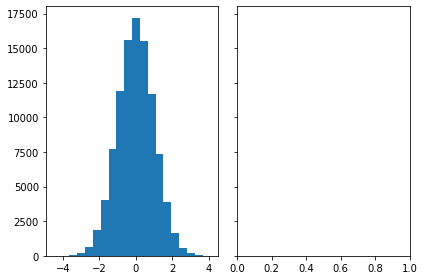

In [80]:
N_points = 100000
n_bins = 20

# Generate a normal distribution, center at x=0 and y=5
x = np.random.randn(N_points)
y = .4 * x + np.random.randn(100000) + 5

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(x, bins=n_bins)


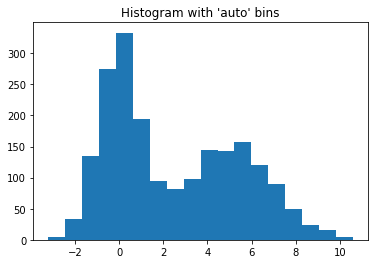

In [84]:
import matplotlib.pyplot as plt
rng = np.random.RandomState(10)  # deterministic random data
a = np.hstack((rng.normal(size=1000),
               rng.normal(loc=5, scale=2, size=1000)))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [89]:
rng.normal(loc=5, scale=2, size=1000)

array([ 4.72096633,  4.22542478,  4.43578161,  8.59293662,  7.78506382,
        6.0789742 ,  6.61273065,  4.13870159,  5.28518382,  6.16379485,
        8.64899152,  3.77993258,  2.97559997,  3.16806959,  3.9505296 ,
        7.31901982,  5.93452724,  3.99549524,  2.3482754 ,  5.85697981,
        4.22847065,  6.80838854,  5.3251492 ,  6.53901529,  6.0780517 ,
        3.44735681,  6.86029033,  6.52854469,  5.97005552,  7.27261192,
        5.05745678,  3.17752514,  1.58779357,  5.83438698,  3.86371246,
        1.43923254,  7.08139579,  4.27945161,  8.51103215,  4.13197973,
        5.68644009,  5.78679787,  5.94092614,  3.62386094,  4.32713358,
        6.66702562,  5.07316423,  6.15957517,  1.42319365,  2.79444462,
        5.1532323 ,  6.99113465,  8.8084182 ,  2.58513919,  3.21447387,
        4.54357104,  5.66052932,  5.27828777,  5.775603  ,  7.63538958,
        4.46247646,  5.40401984,  4.13644748,  2.03303882,  4.05090588,
        5.81881172,  5.74819858,  6.84664101,  5.19315194,  6.45

In [91]:
a=np.hstack(rng.normal(size=20))
a

array([ 1.42970443, -1.26525277,  0.33972331,  0.41262474, -0.24008959,
        1.91046804, -0.73258957,  1.34206198,  1.02572328,  1.71463185,
       -1.67634236, -0.26116035,  0.22610981,  0.31638673,  0.01403467,
        1.0703316 , -0.24467394,  0.7299954 , -0.49565868, -0.193291  ])

(array([2., 2., 5., 4., 3., 4.]),
 array([-1.67634236, -1.07854063, -0.4807389 ,  0.11706284,  0.71486457,
         1.3126663 ,  1.91046804]),
 <BarContainer object of 6 artists>)

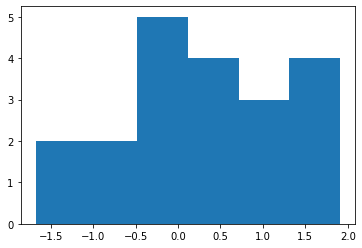

In [94]:
plt.hist(a, bins='auto')

In [87]:
rng.normal(loc=5, scale=2, size=1000)

array([ 5.4439713 , 10.25021194,  2.03608535,  3.47616126,  3.70322266,
        2.18407964,  4.26091047,  8.98858346,  3.70488234,  3.83114824,
        5.11641323,  2.09003927,  3.58794707,  8.61112351,  6.74400928,
        3.62645046,  6.57680249,  2.91305833,  7.6213496 ,  1.48685956,
        7.07067913,  3.0313167 ,  5.67240294,  6.62202187,  3.97898159,
        3.63782296,  5.34087002,  6.52142515,  3.96785164,  3.70430312,
        3.09840407,  5.72116823,  7.70614335,  2.31817436,  6.5880564 ,
        3.88065462,  4.6899336 ,  4.46307323,  6.17384574,  7.83647698,
        7.31521858,  4.31709897,  7.51550882,  6.46149704,  4.3023911 ,
        2.73075624,  1.84937332,  5.71941677,  7.96170899,  2.19907771,
        7.90434576,  6.75515191,  8.6450554 ,  3.06457293,  3.8858261 ,
        6.46546642,  7.08095372,  7.74447688,  2.08199756,  2.01116269,
        6.12391058,  4.33974886,  3.10179666,  7.54794672,  5.76993117,
        5.38722921,  8.66057126,  6.23242364,  7.50537172,  5.30

In [98]:
x=np.zeros((100,3,4))

In [99]:
x

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [102]:
x[0:-1][0][0]

array([0., 0., 0., 0.])

In [103]:
x=[]
x.append('xzzx')
x

['xzzx']

In [104]:
x=[0.234234234,0.24323453543]
str(x)

'[0.234234234, 0.24323453543]'

In [106]:
y=[]
for x in x:
    y.append(str(x)[:3])
    

In [107]:
y

['0.2', '0.2']

In [118]:
x=rng.choice((0,1,2,3,4,5),size=1,p=[1/2,0,0,1/6,1/6,1/6]) 
x[0]

0

In [142]:
x=np.random.rand(3,4)

In [143]:
x

array([[0.63200708, 0.8569491 , 0.97629794, 0.13107902],
       [0.45096687, 0.09689266, 0.25196495, 0.1184301 ],
       [0.85382086, 0.439083  , 0.09793428, 0.89972603]])

In [144]:
x[1]

array([0.45096687, 0.09689266, 0.25196495, 0.1184301 ])

In [148]:
x=np.vstack((x,np.random.rand(1,4)))

In [149]:
x

array([[0.63200708, 0.8569491 , 0.97629794, 0.13107902],
       [0.45096687, 0.09689266, 0.25196495, 0.1184301 ],
       [0.85382086, 0.439083  , 0.09793428, 0.89972603],
       [0.        , 1.        , 2.        , 3.        ],
       [0.11327305, 0.41862788, 0.42677599, 0.60675869]])

In [163]:
y=np.empty((1,3))

In [164]:
y

array([[1., 2., 3.]])

In [165]:
y=np.vstack((y,[1,2.23432,3.3453]))
y

array([[1.     , 2.     , 3.     ],
       [1.     , 2.23432, 3.3453 ]])

In [168]:
pi,px,py,pz=np.random.rand(4,1)

In [177]:
prob_dist_mat=np.zeros((4,1))

prob_dist_mat=np.append([prob_dist_mat,[pi,pz,py,px]])
prob_dist_mat=np.vstack([prob_dist_mat,[pi,px,pz,py]])
prob_dist_mat=np.vstack([prob_dist_mat,[pi,py,px,pz]])
prob_dist_mat=np.vstack([prob_dist_mat,[pi,py,pz,px]])
prob_dist_mat=np.vstack([prob_dist_mat,[pi,pz,px,py]])

TypeError: _append_dispatcher() missing 1 required positional argument: 'values'

In [176]:
prob_dist_mat

array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.70669659],
       [0.37625123],
       [0.94947549],
       [0.50489129],
       [0.70669659],
       [0.50489129],
       [0.37625123],
       [0.94947549],
       [0.70669659],
       [0.94947549],
       [0.50489129],
       [0.37625123],
       [0.70669659],
       [0.94947549],
       [0.37625123],
       [0.50489129],
       [0.70669659],
       [0.37625123],
       [0.50489129],
       [0.94947549]])

In [178]:
prob_dist_mat=np.zeros((4,1))

prob_dist_mat=np.append(prob_dist_mat,[pi,pz,py,px])


In [179]:
prob_dist_mat

array([0.        , 0.        , 0.        , 0.        , 0.70669659,
       0.37625123, 0.94947549, 0.50489129])

In [187]:
            prob_dist_mat=np.array([[pi,px,py,pz]])
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,pz,py,px]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,px,pz,py]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,py,px,pz]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,py,pz,px]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,pz,px,py]]),axis=0)

In [188]:
prob_dist_mat

array([[[0.70669659],
        [0.50489129],
        [0.94947549],
        [0.37625123]],

       [[0.70669659],
        [0.37625123],
        [0.94947549],
        [0.50489129]],

       [[0.70669659],
        [0.50489129],
        [0.37625123],
        [0.94947549]],

       [[0.70669659],
        [0.94947549],
        [0.50489129],
        [0.37625123]],

       [[0.70669659],
        [0.94947549],
        [0.37625123],
        [0.50489129]],

       [[0.70669659],
        [0.37625123],
        [0.50489129],
        [0.94947549]]])

In [219]:
prob_dist

[0.1, 0.3, 0.3, 0.3]

In [200]:
            prob_dist_mat=np.array([[pi,px,py,pz]])
            prob_dist_mat=np.append(prob_dist_mat,[[pi,pz,py,px]],axis=0)

In [204]:
prob_dist_mat[1][0][0]

0.7066965875778028

In [218]:
prob_dist_mat=np.empty((6,4))
prob_dist_mat[0]=pi,px,py,pz
prob_dist_mat[1]=pi,pz,py,px
prob_dist_mat[2]=pi,px,pz,py
prob_dist_mat[3]=pi,py,px,pz
prob_dist_mat[4]=pi,py,pz,px
prob_dist_mat[5]=pi,pz,px,py

prob_dist_mat[5]

<ipython-input-218-4362b8c5d86a>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  prob_dist_mat[0]=pi,px,py,pz
<ipython-input-218-4362b8c5d86a>:3: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  prob_dist_mat[1]=pi,pz,py,px
<ipython-input-218-4362b8c5d86a>:4: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError

array([0.70669659, 0.37625123, 0.50489129, 0.94947549])

In [214]:
prob_dist_mat
prob_dist_mat[0]=pi,px,py,pz
prob_dist_mat[1]=pi,pz,py,px
prob_dist_mat[2]=pi,px,pz,py
prob_dist_mat[3]=pi,py,px,pz
prob_dist_mat[4]=pi,py,pz,px
prob_dist_mat[5]=pi,pz,px,py
prob_dist_mat


<ipython-input-214-2a5476538a04>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  prob_dist_mat[0]=pi,px,py,pz
<ipython-input-214-2a5476538a04>:3: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  prob_dist_mat[1]=pi,pz,py,px
<ipython-input-214-2a5476538a04>:4: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError

array([[0.70669659, 0.50489129, 0.94947549, 0.37625123],
       [0.70669659, 0.37625123, 0.94947549, 0.50489129],
       [0.70669659, 0.50489129, 0.37625123, 0.94947549],
       [0.70669659, 0.94947549, 0.50489129, 0.37625123],
       [0.70669659, 0.94947549, 0.37625123, 0.50489129],
       [0.70669659, 0.37625123, 0.50489129, 0.94947549]])

In [ ]:
prob_dist_mat[0]=np.array([[pi,px,py,pz]])
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,pz,py,px]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,px,pz,py]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,py,px,pz]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,py,pz,px]]),axis=0)
            prob_dist_mat=np.concatenate((prob_dist_mat,[[pi,pz,px,py]]),axis=0)

In [232]:
prob_dist_mat=np.zeros((2,1))
prob_dist_mat[0]=pi,px,py,pz
prob_dist_mat[1]=pi,pz,py,px

<ipython-input-232-9cb849a85bb6>:2: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  prob_dist_mat[0]=pi,px,py,pz


ValueError: could not broadcast input array from shape (4,) into shape (1,)

In [249]:
a=np.array([[1,3]])
b=np.array([[4,5]])
c=np.concatenate((b,a),axis=0)
d=np.concatenate((c,a),axis=0)
d[0]

array([4, 5])

In [262]:
perm_rates=[1/6,1/6,1/6,1/6,1/6,1/6]
perm_vec=np.zeros(100,dtype=int)
for i in range(0,len(perm_vec)):
    x=rng.choice((0,1,2,3,4,5),size=1,p=perm_rates) 
    perm_vec[i]=x[0]
    
len(perm_vec[perm_vec>0])
perm_vec

array([4, 3, 5, 4, 4, 3, 3, 0, 5, 1, 0, 4, 2, 3, 4, 2, 1, 5, 3, 4, 5, 5,
       1, 2, 1, 1, 3, 5, 1, 5, 4, 3, 2, 3, 4, 4, 4, 5, 0, 4, 4, 3, 0, 2,
       4, 3, 3, 3, 4, 5, 3, 4, 2, 2, 0, 2, 0, 3, 4, 1, 5, 3, 5, 0, 3, 4,
       4, 3, 4, 0, 5, 3, 5, 0, 3, 1, 1, 5, 3, 3, 5, 0, 5, 3, 5, 4, 5, 0,
       0, 0, 2, 2, 3, 3, 5, 5, 3, 1, 1, 1])

In [ ]:
prob_dist_mat=[0,1,2,3,4,5]
prob_dist_mat[0]=[pi,px,py,pz]
prob_dist_mat[1]=[pi,pz,py,px]
prob_dist_mat[2]=[pi,px,pz,py]
prob_dist_mat[3]=[pi,py,px,pz]
prob_dist_mat[4]=[pi,py,pz,px]
prob_dist_mat[5]=[pi,pz,px,py]

In [289]:
def permute_error_Pauli(error_Pauli,perm_vec):  
#XYZ,ZYX,XZY,YXZ,YZX,ZXY
    n_qubits=len(error_Pauli)
    for i in range(n_qubits):
        #if perm_vec[i]==0: XYZ
        if perm_vec[i]==1: #ZYX
            if error_Pauli[i]=='X':
                error_Pauli[i]='Z'
            elif error_Pauli[i]=='Z':
                error_Pauli[i]='X'

        elif perm_vec[i]==2: #XZY
            if error_Pauli[i]=='Y':
                error_Pauli[i]='Z'
            elif error_Pauli[i]=='Z':
                error_Pauli[i]='Y'
    
        elif perm_vec[i]==3: #YXZ
            if error_Pauli[i]=='X':
                error_Pauli[i]='Y'
            elif error_Pauli[i]=='Y':
                error_Pauli[i]='X'

        elif perm_vec[i]==4: #YZX
            if error_Pauli[i]=='X':
                error_Pauli[i]='Y'
            elif error_Pauli[i]=='Y':
                error_Pauli[i]='Z'
            elif error_Pauli[i]=='Z':
                error_Pauli[i]='X'                    

        elif perm_vec[i]==5: #ZXY
            if error_Pauli[i]=='X':
                error_Pauli[i]='Z'
            elif error_Pauli[i]=='Y':
                error_Pauli[i]='X'
            elif error_Pauli[i]=='Z':
                error_Pauli[i]='Y'               

#     step_error=pt.pauli_to_bsf(''.join(error_Pauli))                                        

    return error_Pauli

seed_sequence = np.random.SeedSequence()
rng = np.random.default_rng()
error_Pauli = rng.choice(('I', 'X', 'Y', 'Z'),size=100,p=prob_dist) #this assumes spatially uniform noise model
error_Pauli

array(['X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'Z', 'Z', 'X', 'X', 'Y', 'X', 'X', 'X', 'X', 'X', 'X', 'X',
       'X', 'Y', 'X', 'X', 'X', 'X', 'Z', 'X', 'Y', 'X', 'Y', 'X', 'Z',
       'X', 'I', 'X', 'X', 'Z', 'Z', 'X', 'I', 'X', 'X', 'Z', 'X', 'X',
       'X', 'X', 'I', 'Z', 'X', 'X', 'X', 'X', 'X', 'X', 'Z', 'Y', 'Z',
       'X', 'I', 'X', 'I', 'X', 'I', 'I', 'X', 'Y', 'X', 'X', 'X', 'Z',
       'Z', 'X', 'X', 'X', 'I', 'X', 'Z', 'X', 'X', 'Z', 'X', 'X', 'X',
       'I', 'X', 'I', 'X', 'X', 'X', 'X', 'X', 'I'], dtype='<U1')

In [291]:
print(perm_vec)

[4 3 5 4 4 3 3 0 5 1 0 4 2 3 4 2 1 5 3 4 5 5 1 2 1 1 3 5 1 5 4 3 2 3 4 4 4
 5 0 4 4 3 0 2 4 3 3 3 4 5 3 4 2 2 0 2 0 3 4 1 5 3 5 0 3 4 4 3 4 0 5 3 5 0
 3 1 1 5 3 3 5 0 5 3 5 4 5 0 0 0 2 2 3 3 5 5 3 1 1 1]


In [292]:
permute_error_Pauli(error_Pauli,perm_vec)

array(['Y', 'Y', 'Z', 'Y', 'Y', 'Y', 'Y', 'X', 'Z', 'Z', 'X', 'Y', 'X',
       'Y', 'X', 'Y', 'Z', 'Z', 'X', 'Y', 'Z', 'Z', 'Z', 'X', 'Z', 'Z',
       'Y', 'X', 'Z', 'Z', 'Y', 'Y', 'Y', 'Y', 'Z', 'Y', 'Z', 'Z', 'Z',
       'Y', 'I', 'Y', 'X', 'Y', 'X', 'Y', 'I', 'Y', 'Y', 'Y', 'Y', 'Y',
       'X', 'X', 'I', 'Y', 'X', 'Y', 'Y', 'Z', 'Z', 'Y', 'Y', 'Y', 'Z',
       'Y', 'I', 'Y', 'I', 'X', 'I', 'I', 'Z', 'Y', 'Y', 'Z', 'Z', 'Y',
       'Z', 'Y', 'Z', 'X', 'I', 'Y', 'Y', 'Y', 'Z', 'Z', 'X', 'X', 'X',
       'I', 'Y', 'I', 'Z', 'Z', 'Y', 'Z', 'Z', 'I'], dtype='<U1')

In [288]:
prob_dist=[0.1,0.7,0.1,0.1]

In [296]:
x=np.random.rand(3,5,8)

In [297]:
x

array([[[0.40395891, 0.14212321, 0.94601757, 0.72166562, 0.47923531,
         0.51379733, 0.55206583, 0.78968663],
        [0.04559106, 0.74766825, 0.80258604, 0.98193651, 0.41562329,
         0.25843089, 0.26531928, 0.95330686],
        [0.45518461, 0.07589177, 0.76553367, 0.70511273, 0.86534684,
         0.05157484, 0.07055423, 0.86372642],
        [0.93219433, 0.14665367, 0.78903574, 0.56785078, 0.10181819,
         0.76577473, 0.45104094, 0.74858237],
        [0.99993433, 0.76850554, 0.71034668, 0.06185301, 0.65210223,
         0.5943002 , 0.79279616, 0.22070892]],

       [[0.4702196 , 0.24413929, 0.13214041, 0.74957459, 0.2430989 ,
         0.79495433, 0.93931417, 0.65563596],
        [0.28707441, 0.75948439, 0.53860309, 0.84271111, 0.52210001,
         0.44031484, 0.22582059, 0.08712933],
        [0.6829757 , 0.91010438, 0.4067369 , 0.10055497, 0.58241598,
         0.83195675, 0.09202543, 0.51784962],
        [0.7687126 , 0.16960366, 0.90723356, 0.6184106 , 0.71988456,
         

In [300]:
x[2]

array([[0.17712049, 0.52016256, 0.56334609, 0.64861263, 0.29248495,
        0.48370932, 0.91157805, 0.5239629 ],
       [0.69723049, 0.12837162, 0.99127686, 0.30413046, 0.72052525,
        0.57327407, 0.41547922, 0.24797832],
       [0.29043544, 0.97872647, 0.48770375, 0.04971819, 0.29607963,
        0.40949993, 0.6464882 , 0.29511605],
       [0.98422706, 0.19955255, 0.35394106, 0.72802656, 0.59483245,
        0.14608429, 0.85068165, 0.24762465],
       [0.44812851, 0.22293673, 0.32375663, 0.12841939, 0.51066224,
        0.59049258, 0.06737816, 0.42092709]])

In [304]:
np.sum(x[2],axis=0)

array([2.597142  , 2.04974993, 2.72002439, 1.85890723, 2.41458452,
       2.20306019, 2.89160528, 1.73560901])

In [302]:
0.17712+0.68+0.29+0.98+0.45

2.5771200000000003

In [332]:
g=nx.Graph()

In [333]:
g.add_edge(1,2)
g.add_edge(2,3)
g.add_edge(2,5)

In [334]:
g

In [335]:
g.add_edge(1,3)
g.add_edge(2,4)
g.add_edge(3,5)

In [336]:
g.edges

EdgeView([(1, 2), (1, 3), (2, 3), (2, 5), (2, 4), (3, 5)])

In [321]:
g.remove_edge(1,2)

In [322]:
g.remove_edge(1,3)

In [323]:
g.edges

EdgeView([(2, 3), (2, 5), (2, 4), (3, 5)])

In [329]:
g.remove_node(1)

In [546]:
g.edges

EdgeView([(3, 5), (0, 1)])

In [543]:
g.nodes

NodeView((3, 5))

In [544]:
e=[1,2,4]
g.remove_nodes_from(e)
g.nodes

NodeView((3, 5))

In [545]:
g.add_edge(0,1)

In [340]:
if g.has_node(2):
    g.remove_node(2)

In [341]:
g.nodes

NodeView((3, 5))

In [549]:
decoder_graph=g
mapping = dict(zip(decoder_graph, range(len(decoder_graph.nodes))))
decoder_graph = nx.relabel_nodes(decoder_graph, mapping) 

In [542]:
L=9

def map(i,j,k,L):
    return int(i+j*L+k*L*L)

rmnodes1=np.array([],dtype=int)
rmnodes2=np.array([],dtype=int)
rmnodes3=np.array([],dtype=int)

if L in range(3,9):
    x=int(np.round(L/3))
    iv=x

    for i in range(iv,iv+x):
        for j in range(iv,iv+x):
            for k in range(iv,iv+x):
                rmnodes1=np.append(rmnodes1,map(i,j,k,L))   
                
if L in range(9,27):
    x=int(np.round(L/3))
    y=int(np.round(x/3))
    y2=int(np.round((L-2*x)/3))
    iv1=x
    iv2=[y,x+y,2*x+y2] 
    
    for i in range(iv,iv+x):
        for j in range(iv,iv+x):
            for k in range(iv,iv+x):
                rmnodes1=np.append(rmnodes1,i+j*Ny+k*Nx*Ny)

    corners=np.array([[0,0,0]],dtype=int)
    for xi in iv2:
        for xj in iv2:
            for xk in iv2:
                if map(xi,xj,xk,L) not in rmnodes1:
                    corners=np.concatenate((corners,[[xi,xj,xk]]),axis=0)
    corners=np.delete(corners,0,0)   
    
    for corner in corners:
        iv,jv,kv=corner
        if iv!=2*x and jv!=2*x and kv!=2*x:
            for i in range(iv,iv+y):
                for j in range(jv,jv+y):
                    for k in range(kv,kv+y):
                        if i+j*Ny+k*Nx*Ny not in rmnodes1:
                            rmnodes2=np.append(rmnodes2,i+j*Ny+k*Nx*Ny)
        else:
            for i in range(iv,iv+y2):
                for j in range(jv,jv+y2):
                    for k in range(kv,kv+y2):
                        if i+j*Ny+k*Nx*Ny not in rmnodes1:
                            rmnodes2=np.append(rmnodes2,i+j*Ny+k*Nx*Ny)  

                            
if L in range(27,37):
    x=int(np.round(L/3))
    y=int(np.round(x/3))
    y2=int(np.round((L-2*x)/3))
    z=int(np.round(y/3))
    z2=int(np.round((x-2*y)/3))
    iv1=x
    iv2=[y,x+y,2*x+y2]
    zr=int(np.round(y2/3))
    zr2=int(np.round((L-2*x-2*y2)/3))
    iv3=[z,y+z,2*y+z2, x+z,x+y+z,x+2*y+z2,2*x+zr,2*x+y2+zr,2*x+2*y2+zr2]

    for i in range(iv,iv+x):
        for j in range(iv,iv+x):
            for k in range(iv,iv+x):
                rmnodes1=np.append(rmnodes1,i+j*Ny+k*Nx*Ny)

    corners=[[0,0,0]]
    for xi in iv2:
        for xj in iv2:
            for xk in iv2:
                if map(xi,xj,xk,L) not in rmnodes1:
                    corners=np.concatenate((corners,[[xi,xj,xk]]),axis=0)
    corners=np.delete(corners,0,0)   

    for corner in corners:
        iv,jv,kv=corner
        if iv!=2*x and jv!=2*x and kv!=2*x:
            for i in range(iv,iv+y):
                for j in range(jv,jv+y):
                    for k in range(kv,kv+y):
                        if i+j*Ny+k*Nx*Ny not in rmnodes1:
                            rmnodes2=np.append(rmnodes2,i+j*Ny+k*Nx*Ny)
        else:
            for i in range(iv,iv+y2):
                for j in range(jv,jv+y2):
                    for k in range(kv,kv+y2):
                        if i+j*Ny+k*Nx*Ny not in rmnodes1:
                            rmnodes2=np.append(rmnodes2,i+j*Ny+k*Nx*Ny) 


    corners2=[[0,0,0]]
    for xi in iv3:
        for xj in iv3:
            for xk in iv3:
                if map(xi,xj,xk,L) not in rmnodes1 and map(xi,xj,xk,L) not in rmnodes2:
                    corners2=np.concatenate((corners,[[xi,xj,xk]]),axis=0)
    corners2=np.delete(corners2,0,0)      

    for corner in corners2:
        iv,jv,kv=corner        
        rmnodes2=np.append(rmnodes2,iv+jv*Ny+kv*Nx*Ny)                            



In [501]:
iv2=np.array([2,5,8])
iv=3
x=3

rmnodes1=[[0,0,0]]
for i in range(iv,iv+x):
    for j in range(iv,iv+x):
        for k in range(iv,iv+x):
            rmnodes1=np.concatenate((rmnodes1,[[i,j,k]]),axis=0)
            
rmnodes1=np.delete(rmnodes1,0,0)        

corners=[[0,0,0]]
for xi in iv2:
    for xj in iv2:
        for xk in iv2:
            if [xi,xj,xk] not in rmnodes1:
                corners=np.concatenate((corners,[[xi,xj,xk]]),axis=0)

corners=np.delete(corners,0,0)        

corners2=[[0,0]]
for xi in iv2:
    for xj in iv2:
        corners2=np.concatenate((corners2,[[xi,xj]]),axis=0)
    
corners2=np.delete(corners2,0,0)        
    

In [502]:
rmnodes1

array([[3, 3, 3],
       [3, 3, 4],
       [3, 3, 5],
       [3, 4, 3],
       [3, 4, 4],
       [3, 4, 5],
       [3, 5, 3],
       [3, 5, 4],
       [3, 5, 5],
       [4, 3, 3],
       [4, 3, 4],
       [4, 3, 5],
       [4, 4, 3],
       [4, 4, 4],
       [4, 4, 5],
       [4, 5, 3],
       [4, 5, 4],
       [4, 5, 5],
       [5, 3, 3],
       [5, 3, 4],
       [5, 3, 5],
       [5, 4, 3],
       [5, 4, 4],
       [5, 4, 5],
       [5, 5, 3],
       [5, 5, 4],
       [5, 5, 5]])

In [505]:
for corner in corners:
    i,j,k=corner
    print(i,j,k)

2 2 2
2 2 8
2 8 2
2 8 8
8 2 2
8 2 8
8 8 2
8 8 8


In [395]:
b = np.array([[5, 6]])
a = np.array([[0,0]])
np.concatenate((a,b),axis=0)

array([[0, 0],
       [5, 6]])

In [415]:
np.empty((3,1),dtype=int)

array([[140684136837616],
       [              0],
       [              0]])

In [477]:
a=np.array([[3,3,4],[2,5,3]])
a

array([[3, 3, 4],
       [2, 5, 3]])

In [476]:
np.isin([[2,3,3]],a)

array([[ True,  True,  True]])

In [463]:
rmnodes1=np.array([[3,3,3],
       [3, 3, 4],
       [3, 3, 5],
       [3, 4, 3],
       [3, 4, 4],
       [3, 4, 5],
       [3, 5, 3],
       [3, 5, 4],
       [3, 5, 5],
       [4, 3, 3],
       [4, 3, 4],
       [4, 3, 5],
       [4, 4, 3],
       [4, 4, 4],
       [4, 4, 5],
       [4, 5, 3],
       [4, 5, 4],
       [4, 5, 5],
       [5, 3, 3],
       [5, 3, 4],
       [5, 3, 5],
       [5, 4, 3],
       [5, 4, 4],
       [5, 4, 5],
       [5, 5, 3],
       [5, 5, 4],
       [5, 5, 5]])

In [464]:
[2,5,8] in rmnodes1

True

In [499]:
iv2=np.array([2,5,8])
iv=3
x=3

L=9

def map(i,j,k,L):
    return int(i+j*L+k*L*L)

rmnodes1=np.array([],dtype=int)
for i in range(iv,iv+x):
    for j in range(iv,iv+x):
        for k in range(iv,iv+x):
            rmnodes1=np.append(rmnodes1,map(i,j,k,L))
            
corners=np.array([],dtype=int)
for xi in iv2:
    for xj in iv2:
        for xk in iv2:
            if map(xi,xj,xk,L) not in rmnodes1:
                corners=np.concatenate((corners,[[xi,xj,xk]]),axis=0)




ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [497]:
rmnodes1

array([273, 354, 435, 282, 363, 444, 291, 372, 453, 274, 355, 436, 283,
       364, 445, 292, 373, 454, 275, 356, 437, 284, 365, 446, 293, 374,
       455])

In [487]:
200 in rmnodes1

False

In [488]:
corners

array([[2, 2, 2],
       [2, 2, 5],
       [2, 2, 8],
       [2, 5, 2],
       [2, 5, 5],
       [2, 5, 8],
       [2, 8, 2],
       [2, 8, 5],
       [2, 8, 8],
       [5, 2, 2],
       [5, 2, 5],
       [5, 2, 8],
       [5, 5, 2],
       [5, 5, 8],
       [5, 8, 2],
       [5, 8, 5],
       [5, 8, 8],
       [8, 2, 2],
       [8, 2, 5],
       [8, 2, 8],
       [8, 5, 2],
       [8, 5, 5],
       [8, 5, 8],
       [8, 8, 2],
       [8, 8, 5],
       [8, 8, 8]])

In [491]:
map(5,5,5,9) not in rmnodes1

False

In [494]:
rmnodes2=np.array([],dtype=int)
L=9
def map2(i,j,L):
    return int(i+j*L)

for i in range(iv,iv+x):
    for j in range(iv,iv+x):
        rmnodes2=np.append(rmnodes2,map2(i,j,L))
        
corners2=[[0,0]]
for xi in iv2:
    for xj in iv2:
        if map2(xi,xj,L) not in rmnodes2:
            corners2=np.concatenate((corners2,[[xi,xj]]),axis=0)
    
corners2=np.delete(corners2,0,0)  

In [495]:
corners2

array([[2, 2],
       [2, 5],
       [2, 8],
       [5, 2],
       [5, 8],
       [8, 2],
       [8, 5],
       [8, 8]])